https://www.kaggle.com/competitions/facebook-recruiting-iv-human-or-bot/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## train.csv / 出價人資料

出價人 數據集，其中包含出價人資訊清單，包括他們的ID、支付帳戶和位址。

In [2]:
train = pd.read_csv('train.csv')

train.shape

(2013, 4)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2013 entries, 0 to 2012
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bidder_id        2013 non-null   object 
 1   payment_account  2013 non-null   object 
 2   address          2013 non-null   object 
 3   outcome          2013 non-null   float64
dtypes: float64(1), object(3)
memory usage: 63.0+ KB


- bidder_id：競標者的唯一識別碼。
- payment_account：與競標者相關聯的付款帳戶。
- address：競標者的郵寄地址。
- outcome：競標者的標籤，表示該競標者是否為機器人。值為 1.0 表示是機器人，值為 0.0 表示是人類。

In [4]:
train.duplicated().sum()

0

In [5]:
train.head()

,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0


outcome
0.0    1910
1.0     103
Name: count, dtype: int64


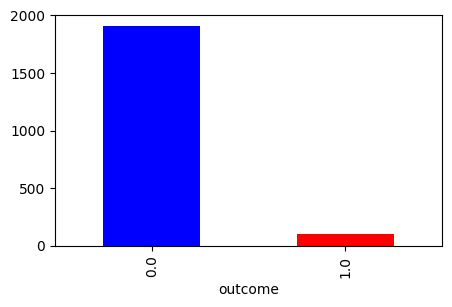

In [6]:
print(train['outcome'].value_counts())

train['outcome'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.gcf().set_size_inches(5, 3)
plt.show()

可以發現 outcome 資料不平衡，可以透過重抽樣（Resampling）來進行資料的平衡。

因為數據量 2013 筆不算大，故預計使用過採樣（Oversampling）。

實際作法採用 SMOTE（Synthetic Minority Oversampling Technique），通過生成新的合成樣本來增加少數類別數據的數量。

## test.csv / 出價人資料

In [7]:
test = pd.read_csv('test.csv')

test.shape

(4700, 3)

## bids.csv / 出價資料

出價 數據集，其中包含不同競價的 760萬 筆出價資料。

In [8]:
bids = pd.read_csv('bids.csv')

bids.shape

(7656334, 9)

In [9]:
bids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7656334 entries, 0 to 7656333
Data columns (total 9 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   bid_id       int64 
 1   bidder_id    object
 2   auction      object
 3   merchandise  object
 4   device       object
 5   time         int64 
 6   country      object
 7   ip           object
 8   url          object
dtypes: int64(2), object(7)
memory usage: 525.7+ MB


- bid_id：此出價的唯一編號。
- bidder_id：競標者的唯一識別碼（與 train.csv 和 test.csv 中的 bidder_id 相同）。
- auction：拍賣活動的唯一識別碼。
- merchandise：競標者進入網站時的「初始商品類別」，不一定是他們實際出價商品的類別。
- device：訪客使用的手機型號。
- time：競標者提交出價的時間。
- country：與 IP 地址相關的國家。
- ip：競標者的 IP 地址。
- url：競標者從哪個網址引導進入的拍賣網站。

In [10]:
bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


In [11]:
bids.duplicated().sum()

0

### 處理缺失值

In [12]:
bids.isna().sum()

bid_id            0
bidder_id         0
auction           0
merchandise       0
device            0
time              0
country        8859
ip                0
url               0
dtype: int64

In [13]:
# 缺失值的比例
bids.isna().sum() / len(bids) # 約 0.12%

bid_id         0.000000
bidder_id      0.000000
auction        0.000000
merchandise    0.000000
device         0.000000
time           0.000000
country        0.001157
ip             0.000000
url            0.000000
dtype: float64

查看缺失值比例後，因為佔總數約 0.12% 資料而已，其實可以考慮直接清掉！

In [14]:
# print(bids.shape) # (7656334, 9)

# bids.dropna(inplace=True)

# print(bids.shape) # (7656334 - 8859 = 7647475, 9)

或我們來思考要用什麼補值的方式！
> e.g. 平均數(mean)、中位數(median)、眾數(mode)

In [15]:
# 秀出那些有遺失值的列
bids[bids.isnull().values==True]

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
1647,1647,dbd340def489066ae13ffa5cd68e6d2917li7,38v0a,jewelry,phone408,9759252578947368,NaN,115.235.196.83,50rtdzaq69sxgi8
1845,1845,dbd340def489066ae13ffa5cd68e6d2917li7,7msk4,jewelry,phone45,9759253684210526,NaN,161.65.211.149,3w7pkfdhqvduki1
1968,1968,ceb6c86354e97d4d849ef5b1364bb0964nxe3,jefix,sporting goods,phone150,9759254210526315,NaN,117.34.233.29,1a1l994pff8hwc4
1982,1982,dbd340def489066ae13ffa5cd68e6d2917li7,uo3lj,jewelry,phone408,9759254315789473,NaN,115.235.196.83,g0k9f3jstsx5pud
2911,2911,cdf76f38b6f46a3bd396a99123d26909xq5c3,jefix,mobile,phone150,9759259526315789,NaN,44.203.207.204,cdr9pz0wkzokbp8
...,...,...,...,...,...,...,...,...,...
7650495,7650495,06a58d4af0fe7ee15324b0e921e8de1260vef,jqx39,mobile,phone125,9709196473684210,NaN,102.141.77.207,xj4r8a6nnv6o9ns
7650591,7650591,626159dd6f2228ede002d9f9340f75b7puk8d,x36iy,jewelry,phone35,9709196947368421,NaN,231.36.69.124,hx1meiyqlpmc77u
7650748,7650748,626159dd6f2228ede002d9f9340f75b7puk8d,obbny,jewelry,phone46,9709197631578947,NaN,11.123.113.3,v5cuis08b67aqfx
7653822,7653822,2a9dcf343aa74fd5a27cc00e04376cd5xlsra,jqx39,jewelry,phone125,9709211052631578,NaN,26.30.167.167,wmznp5194pj56ya


In [16]:
bids['country'].value_counts()

country
in    1788731
ng     586586
id     453611
tr     319574
us     318103
       ...   
an          2
er          2
gp          2
mh          1
tc          1
Name: count, Length: 199, dtype: int64

In [17]:
bids['country'].mode(), bids['country'].mode()[0]

(0    in
 Name: country, dtype: object,
 'in')

In [18]:
# 檢查變數的分布情況。
# 如果某個類別明顯佔據大多數，用 mode (眾數) 來填補缺失值是合理且常用的方法。

bids['country'] = bids['country'].fillna(bids['country'].mode()[0])

bids['country'].isna().sum()


0

In [19]:
bids.iloc[1647] # 原本有缺失值的列，已補值

bid_id                                          1647
bidder_id      dbd340def489066ae13ffa5cd68e6d2917li7
auction                                        38v0a
merchandise                                  jewelry
device                                      phone408
time                                9759252578947368
country                                           in
ip                                    115.235.196.83
url                                  50rtdzaq69sxgi8
Name: 1647, dtype: object

## 資料合併
使用 bidder_id 作為 key 將 train.csv 和 bids.csv 合併

In [20]:
bidder_unique = bids.groupby('bidder_id').nunique().reset_index()
bidder_unique

,bidder_id,bid_id,auction,merchandise,device,time,country,ip,url
0,001068c415025a009fee375a12cff4fcnht8y,1,1,1,1,1,1,1,1
1,002d229ffb247009810828f648afc2ef593rb,2,1,1,2,2,1,1,1
2,0030a2dd87ad2733e0873062e4f83954mkj86,1,1,1,1,1,1,1,1
3,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3,3,1,3,3,1,3,2
4,00486a11dff552c4bd7696265724ff81yeo9v,20,13,1,8,20,1,10,7
...,...,...,...,...,...,...,...,...,...
6609,ffbc0fdfbf19a8a9116b68714138f2902cc13,25075,637,1,792,23487,102,18726,8039
6610,ffc4e2dd2cc08249f299cab46ecbfacfobmr3,22,15,1,13,22,6,18,12
6611,ffd29eb307a4c54610dd2d3d212bf3bagmmpl,1,1,1,1,1,1,1,1
6612,ffd62646d600b759a985d45918bd6f0431vmz,664,55,1,96,664,1,37,144


In [21]:
train_bidder_unique = train.merge(bidder_unique, on='bidder_id', how='left')
train_bidder_unique.rename(
  columns={
    'bid_id': 'bid_count',
    'auction': 'auction_count', 
    'merchandise': 'merchandise_count', 
    'device': 'device_count', 
    'time': 'time_count', 
    'country': 'country_count', 
    'ip': 'ip_count', 
    'url': 'url_count'
  }, 
  inplace=True
)

train_bidder_unique

,bidder_id,payment_account,address,outcome,bid_count,auction_count,merchandise_count,device_count,time_count,country_count,ip_count,url_count
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,24.0,18.0,1.0,14.0,24.0,6.0,20.0,1.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,3.0,1.0,1.0,2.0,3.0,1.0,3.0,2.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,4.0,4.0,1.0,2.0,4.0,1.0,4.0,2.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,155.0,23.0,1.0,53.0,155.0,2.0,123.0,91.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2008,369515b3af4f8ca582f90271d30b14b6r52aw,a1f85275793c4a782f0a668711f41b927ivc9,e6882cf204a9482edd042b6e31791dfctxzx8,0.0,36.0,25.0,1.0,4.0,33.0,4.0,5.0,2.0
2009,f939c17ffc7c39ac9b35b69e5e75179fv9pe2,a3d2de7675556553a5f08e4c88d2c2286s1m2,b9b03d5a127eb07aeb9163cdcf524e1344ac9,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2010,c806dbb2decba0ed3c4ff5e2e60a74c2wjvbl,a3d2de7675556553a5f08e4c88d2c22856leq,d02c2b288b8aabd79ff47118aff41a2dqwzwc,0.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0
2011,0381a69b7a061e9ace2798fd48f1f537mgq57,fd87037ce0304077079c749f420f0b4c54uo0,f030a221726fbcdfc4dc7dfd1b381a112hieq,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [22]:
train_bidder_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2013 entries, 0 to 2012
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bidder_id          2013 non-null   object 
 1   payment_account    2013 non-null   object 
 2   address            2013 non-null   object 
 3   outcome            2013 non-null   float64
 4   bid_count          1984 non-null   float64
 5   auction_count      1984 non-null   float64
 6   merchandise_count  1984 non-null   float64
 7   device_count       1984 non-null   float64
 8   time_count         1984 non-null   float64
 9   country_count      1984 non-null   float64
 10  ip_count           1984 non-null   float64
 11  url_count          1984 non-null   float64
dtypes: float64(9), object(3)
memory usage: 188.8+ KB


In [23]:
# 找出有 nan 的行數
train_bidder_unique[train_bidder_unique.isnull().any(axis=1)]

,bidder_id,payment_account,address,outcome,bid_count,auction_count,merchandise_count,device_count,time_count,country_count,ip_count,url_count
49,5f50c6187a179e2ee7ba2fbcfc845c7a1smgr,7326f0a1592b18cb1e6ed7c8ebbd03a72qf7p,a3d2de7675556553a5f08e4c88d2c228uaoqg,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,02bde521e763e4f4e590e8368149e04a96il9,a3d2de7675556553a5f08e4c88d2c2286r1lb,935d2083173e96f099816c1b1f7ee249kk8zo,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175,dd661e2d6e79a5b3e66c82373d50f3ee86k85,e805bf9d2399ddc37a194e04703a333c7bv82,2c2b8b44b1615ef6d632fb115a85794djmktr,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,908ce7060337fd8550760a100921f6f7wsemn,a3d2de7675556553a5f08e4c88d2c2282yldz,39b2bdec29461f8a0ae2a5a5b01d259fik8r7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262,b64c209b3d1d91a663d134961af89125u0s9a,f7558102989f5665bbbea00358f8434adf9o9,5c9de1da50cc32a29ffd596ae24cd2be24cly,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,96b1df591dbbf3a002578574671d9ff1rmzev,a3d2de7675556553a5f08e4c88d2c2288tx3v,1a1d480ca96a50e5fa8af28cf9121d80gx8g2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299,d2138bce99f535c244dab68652ccfa2enshxk,72a51aa2faf94e7ffdf736fdb389d4efpyojt,458d233d676d8f62406213ab319b8334dbdxh,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305,c08e5e3325e2f4fea171f24ca018e675we8kj,efd15ad70741e38f212ac919ca569615r3g33,81d6c498369ab4af3fea529406dc7d96flle8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339,187636e527504df29bf42d4a2b7767e54bgv7,a3d2de7675556553a5f08e4c88d2c2281swzb,a3d2de7675556553a5f08e4c88d2c2281rrln,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
364,74f153bd134afc92866a6bc5cceb2088120y0,a3d2de7675556553a5f08e4c88d2c228fd0s8,796f3dd849480319c21677833dc1a6c87c6p1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
train_bidder_unique.dropna(inplace=True)

## 資料集切分 train / validation

In [25]:
X = train_bidder_unique.drop([
  'bidder_id',
  'payment_account',
  'address',
  'outcome'
], axis=1)

Y = train_bidder_unique['outcome']

In [26]:
Y.value_counts()

outcome
0.0    1881
1.0     103
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
ａ
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1587, 8), (397, 8), (1587,), (397,))

In [28]:
# SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

x_train_smote.shape, y_train_smote.shape

((3014, 8), (3014,))

In [29]:
y_train_smote.value_counts()

outcome
0.0    1507
1.0    1507
Name: count, dtype: int64

In [30]:
x_train_smote

,bid_count,auction_count,merchandise_count,device_count,time_count,country_count,ip_count,url_count
0,33.000000,8.000000,1.0,21.000000,33.000000,8.000000,30.000000,16.000000
1,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
2,17.000000,11.000000,1.0,9.000000,17.000000,2.000000,15.000000,2.000000
3,7.000000,6.000000,1.0,3.000000,7.000000,2.000000,6.000000,1.000000
4,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...
3009,28212.009849,719.582334,1.0,984.626148,26372.758970,68.922968,20122.194986,2083.583059
3010,616.353555,11.141422,1.0,18.656589,605.959622,5.989905,53.585927,114.464793
3011,645.893871,111.808503,1.0,79.625809,644.525162,30.312905,207.601727,387.439793
3012,2954.155643,241.965339,1.0,133.750113,2929.786590,35.048030,2136.292016,48.749660


In [31]:
y_train_smote

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3009    1.0
3010    1.0
3011    1.0
3012    1.0
3013    1.0
Name: outcome, Length: 3014, dtype: float64

## 模型指標、性能

In [90]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

def evaluate_model(y_test, y_pred, class_labels=["Class 0", "Class 1"], plot=True):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    if plot:
        print(f"tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}")

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
        fig, ax = plt.subplots(figsize=(3, 3))
        disp.plot(cmap="binary", ax=ax)
        plt.ylabel('Outcome')
        plt.xlabel('Predicted Outcome')
        plt.show()
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    if plot:
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1-Score: {f1}")
    
    return precision, recall, f1

### 所需

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


## LR

In [34]:
from sklearn.linear_model import LogisticRegression

lr_pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('lr', LogisticRegression())
])

lr_pipeline.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lr', LogisticRegression())])

tn: 374, fp: 0, fn: 22, tp: 1


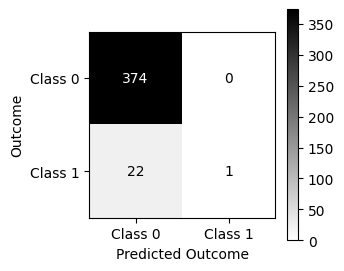

Precision: 1.0
Recall: 0.043478260869565216
F1-Score: 0.08333333333333333


(1.0, 0.043478260869565216, 0.08333333333333333)

In [35]:
evaluate_model(y_test, lr_pipeline.predict(x_test))

In [36]:
lr_cw_pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('lr', LogisticRegression(class_weight="balanced"))
])

lr_cw_pipeline.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lr', LogisticRegression(class_weight='balanced'))])

tn: 314, fp: 60, fn: 14, tp: 9


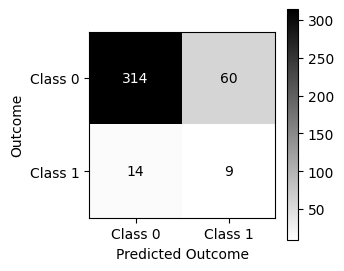

Precision: 0.13043478260869565
Recall: 0.391304347826087
F1-Score: 0.1956521739130435


(0.13043478260869565, 0.391304347826087, 0.1956521739130435)

In [37]:
evaluate_model(y_test, lr_cw_pipeline.predict(x_test))

In [38]:
lr_cw_smote_pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('lr', LogisticRegression(class_weight="balanced"))
])

lr_cw_smote_pipeline.fit(x_train_smote, y_train_smote)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lr', LogisticRegression(class_weight='balanced'))])

tn: 313, fp: 61, fn: 14, tp: 9


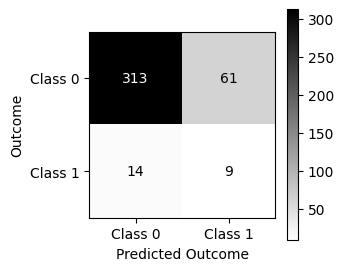

Precision: 0.12857142857142856
Recall: 0.391304347826087
F1-Score: 0.1935483870967742


(0.12857142857142856, 0.391304347826087, 0.1935483870967742)

In [39]:
evaluate_model(y_test, lr_cw_smote_pipeline.predict(x_test))

## SVM

In [40]:
from sklearn.svm import SVC

In [41]:
svc_rbf_cw_pipeline = Pipeline([
  ("scaler", StandardScaler()),
  ("svc", SVC(
      kernel="rbf",
      class_weight="balanced",
      random_state=42
    )
  )
])

svc_rbf_cw_pipeline.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', SVC(class_weight='balanced', random_state=42))])

tn: 296, fp: 78, fn: 7, tp: 16


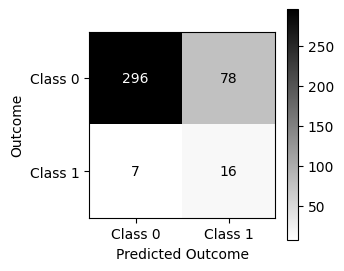

Precision: 0.1702127659574468
Recall: 0.6956521739130435
F1-Score: 0.27350427350427353


(0.1702127659574468, 0.6956521739130435, 0.27350427350427353)

In [42]:
evaluate_model(y_test, svc_rbf_cw_pipeline.predict(x_test))

In [43]:
svc_rbf_cw_smote_pipeline = Pipeline([
  ("scaler", StandardScaler()),
  ("svc", SVC(
      kernel="rbf",
      class_weight="balanced",
      random_state=42
    )
  )
])

svc_rbf_cw_smote_pipeline.fit(x_train_smote, y_train_smote)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', SVC(class_weight='balanced', random_state=42))])

tn: 305, fp: 69, fn: 8, tp: 15


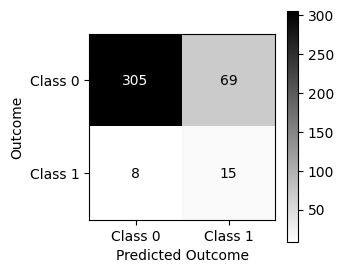

Precision: 0.17857142857142858
Recall: 0.6521739130434783
F1-Score: 0.2803738317757009


(0.17857142857142858, 0.6521739130434783, 0.2803738317757009)

In [44]:
evaluate_model(y_test, svc_rbf_cw_smote_pipeline.predict(x_test))

## Decision Tree

In [45]:
from sklearn.tree import DecisionTreeClassifier

In [46]:
tree_cw = DecisionTreeClassifier(
  class_weight="balanced",
  random_state=42
)

tree_cw.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

tn: 368, fp: 6, fn: 17, tp: 6


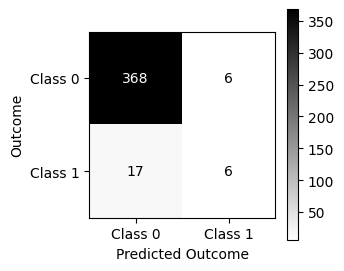

Precision: 0.5
Recall: 0.2608695652173913
F1-Score: 0.34285714285714286


(0.5, 0.2608695652173913, 0.34285714285714286)

In [47]:
evaluate_model(y_test, tree_cw.predict(x_test))

In [48]:
tree_cw_smote = DecisionTreeClassifier(
  class_weight="balanced",
  random_state=42
)

tree_cw_smote.fit(x_train_smote, y_train_smote)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

tn: 356, fp: 18, fn: 15, tp: 8


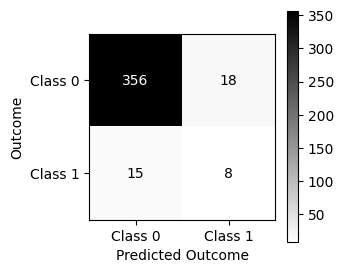

Precision: 0.3076923076923077
Recall: 0.34782608695652173
F1-Score: 0.32653061224489793


(0.3076923076923077, 0.34782608695652173, 0.32653061224489793)

In [49]:
evaluate_model(y_test, tree_cw_smote.predict(x_test))

## Hard Voting

In [50]:
from sklearn.ensemble import VotingClassifier

hard_voting = VotingClassifier([
  ('lr', lr_cw_pipeline),
  ('svc', svc_rbf_cw_pipeline),
  ('tree', tree_cw)
], voting='hard')

hard_voting.fit(x_train, y_train)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('lr',
                                               LogisticRegression(class_weight='balanced'))])),
                             ('svc',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('svc',
                                               SVC(class_weight='balanced',
                                                   random_state=42))])),
                             ('tree',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     random_state=42))])

tn: 322, fp: 52, fn: 12, tp: 11


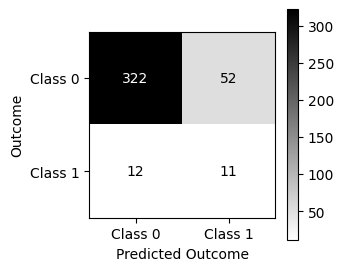

Precision: 0.1746031746031746
Recall: 0.4782608695652174
F1-Score: 0.2558139534883721


(0.1746031746031746, 0.4782608695652174, 0.2558139534883721)

In [51]:
evaluate_model(y_test, hard_voting.predict(x_test))

## Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
random_forest_cw = RandomForestClassifier(
  class_weight="balanced",
  random_state=42
)

random_forest_random_search = RandomizedSearchCV(
  random_forest_cw,
  param_distributions={
    'n_estimators': np.arange(100, 1000, 100),
    'max_depth': np.arange(10, 110, 10),
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 10),
  },
  n_iter=10,
  cv=5,
  scoring='f1',
  n_jobs=-1,
  random_state=42
)

random_forest_random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
                   random_state=42, scoring='f1')

In [54]:
random_forest_random_search.best_params_

{'n_estimators': 600,
 'min_samples_split': 9,
 'min_samples_leaf': 3,
 'max_depth': 20}

tn: 371, fp: 3, fn: 16, tp: 7


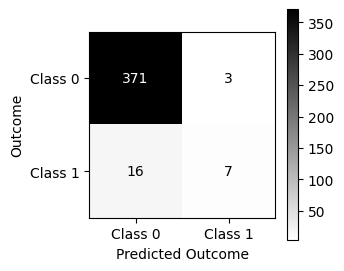

Precision: 0.7
Recall: 0.30434782608695654
F1-Score: 0.42424242424242425


(0.7, 0.30434782608695654, 0.42424242424242425)

In [55]:
evaluate_model(y_test, random_forest_random_search.best_estimator_.predict(x_test))

## AdaBoost

In [56]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [57]:
tree_clf = DecisionTreeClassifier(max_depth=1, random_state=42)
ada_clf = AdaBoostClassifier(
  estimator=tree_clf,
  random_state=42,
  algorithm="SAMME"
)

ada_random_search = RandomizedSearchCV(
  ada_clf,
  param_distributions={
    'n_estimators': np.arange(50, 500, 50),
    'learning_rate': np.linspace(0.1, 1, 10)
  },
  n_iter=10,
  cv=5,
  scoring='f1',
  n_jobs=-1,
  random_state=42
)

ada_random_search.fit(x_train_smote, y_train_smote)

RandomizedSearchCV(cv=5,
                   estimator=AdaBoostClassifier(algorithm='SAMME',
                                                estimator=DecisionTreeClassifier(max_depth=1,
                                                                                 random_state=42),
                                                random_state=42),
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450])},
                   random_state=42, scoring='f1')

tn: 310, fp: 64, fn: 5, tp: 18


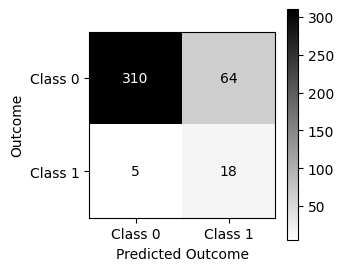

Precision: 0.21951219512195122
Recall: 0.782608695652174
F1-Score: 0.34285714285714286


(0.21951219512195122, 0.782608695652174, 0.34285714285714286)

In [58]:
evaluate_model(y_test, ada_random_search.best_estimator_.predict(x_test))

## GradientBoosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=42)
  
gbc_random_search = RandomizedSearchCV(
  gbc,
  param_distributions={
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': np.arange(3, 10),
    'learning_rate': np.linspace(0.1, 1, 10),
    'subsample': np.linspace(0.5, 1, 10),
    'max_features': np.linspace(0.5, 1, 10)
  },
  n_iter=10,
  cv=5,
  scoring='f1',
  n_jobs=-1,
  random_state=42
)

gbc_random_search.fit(x_train_smote, y_train_smote)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'max_features': array([0.5       , 0.55555556, 0.61111111, 0.66666667, 0.72222222,
       0.77777778, 0.83333333, 0.88888889, 0.94444444, 1.        ]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450]),
                                        'subsample': array([0.5       , 0.55555556, 0.61111111, 0.66666667, 0.72222222,
       0.77777778, 0.83333333, 0.88888889, 0.94444444, 1.        ])},
                   random_state=42, scoring='f1')

In [ ]:
gbc_random_search.best_params_

{'subsample': 0.7777777777777778,
 'n_estimators': 300,
 'max_features': 1.0,
 'max_depth': 9,
 'learning_rate': 0.1}

tn: 358, fp: 16, fn: 12, tp: 11


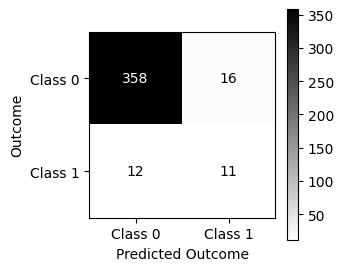

Precision: 0.4074074074074074
Recall: 0.4782608695652174
F1-Score: 0.44


(0.4074074074074074, 0.4782608695652174, 0.44)

In [ ]:
evaluate_model(y_test, gbc_random_search.best_estimator_.predict(x_test))

## XGBoost

In [59]:
from xgboost import XGBClassifier

In [ ]:
xgb_clf = XGBClassifier(
  random_state=42
)

xgb_random_search = RandomizedSearchCV(
  xgb_clf,
  param_distributions={
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': np.arange(3, 10),
    'learning_rate': np.linspace(0.1, 1, 10),
    'gamma': np.linspace(0, 1, 10),
    'subsample': np.linspace(0.5, 1, 10),
    'colsample_bytree': np.linspace(0.5, 1, 10),
    'reg_alpha': np.linspace(0, 1, 10),
    'reg_lambda': np.linspace(0, 1, 10)
  },
  n_iter=10,
  cv=5,
  scoring='f1',
  n_jobs=-1,
  random_state=42
)

xgb_random_search.fit(x_train_smote, y_train_smote)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'reg_alpha': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'reg_lambda': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'subsample': array([0.5       , 0.55555556, 0.61111111, 0.66666667, 0.72222222,
       0.77777778, 0.83333333, 0.88888889, 0.94444444, 1.        ])},
                   random_state=42, scoring='f1')

In [61]:
xgb_random_search.best_params_

{'subsample': 0.8333333333333333,
 'reg_lambda': 0.3333333333333333,
 'reg_alpha': 0.0,
 'n_estimators': 100,
 'max_depth': 9,
 'learning_rate': 0.1,
 'gamma': 0.0,
 'colsample_bytree': 1.0}

tn: 358, fp: 16, fn: 11, tp: 12


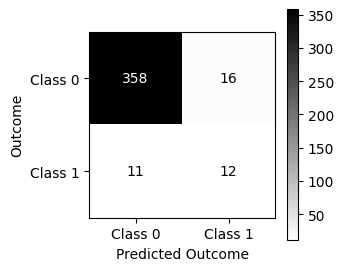

Precision: 0.42857142857142855
Recall: 0.5217391304347826
F1-Score: 0.47058823529411764


(0.42857142857142855, 0.5217391304347826, 0.47058823529411764)

In [62]:
evaluate_model(y_test, xgb_random_search.best_estimator_.predict(x_test))

# Summary

In [91]:
# 總結各模型的表現

models = {
  "Logistic Regression": lr_cw_smote_pipeline,
  "SVC RBF": svc_rbf_cw_smote_pipeline,
  "Decision Tree": tree_cw_smote,
  "Random Forest": random_forest_random_search.best_estimator_,
  "AdaBoost": ada_random_search.best_estimator_,
  "Gradient Boosting": gbc_random_search.best_estimator_,
  "XGBoost": xgb_random_search.best_estimator_
}

model_scores = {}

for name, model in models.items():
  model_scores[name] = {
    "Precision": None,
    "Recall": None,
    "F1-Score": None
  }
  model_scores[name]["Precision"], model_scores[name]["Recall"], model_scores[name]["F1-Score"] = evaluate_model(y_test, model.predict(x_test), plot=False)

model_scores_df = pd.DataFrame(model_scores)
model_scores_df

,Logistic Regression,SVC RBF,Decision Tree,Random Forest,AdaBoost,Gradient Boosting,XGBoost
Precision,0.128571,0.178571,0.307692,0.700000,0.219512,0.407407,0.428571
Recall,0.391304,0.652174,0.347826,0.304348,0.782609,0.478261,0.521739
F1-Score,0.193548,0.280374,0.326531,0.424242,0.342857,0.440000,0.470588
